# Calculate Entropy of Pion Valence Quark

* Domain of Definition: [0,1]
* Define Shannon Entropy:
$$S = -\int_0^1 P(x)\log{P(x)} dx$$
* Normalization: $$\int_0^1 P(x) dx = 1$$
* Symmetry (first order moment): $$\int_0^1 (2x-1) P(x)  dx = 0$$
* Second Order Moment: $$\int_0^1 (2x-1)^2 P(x) dx = \mu_2$$
* Higher Order Moment: $$\int_0^1 (2x-1)^n P(x) dx = \mu_n$$

## Define Functional Basis

In [1]:
import numpy as np
from math import cos, pi, sin

# define a[j] array
n = 50
a_coefficient = np.zeros(n)
num_moment = 6 
mu = np.zeros(num_moment)
sigma = np.zeros(num_moment)

# define functional basis
def P(a, x):
    P_value = 0
    for i in range (0, n):
        # Define P_j(a_j, x)
        P_value += a[i]*(sin((2*i+1)*pi*x))
    return P_value

## Define Basic Operators

$\begin{aligned}
&\frac{d}{dx}\\
&\frac{\partial}{\partial a_j}\\
&\frac{\partial^2}{\partial a_j \partial a_k}\\
&\int_0^1 dx\\
&S=-\int_0^1 P(x)\log{P(x)} dx\\
&\mu_n=\int_0^1 (2x-1)^n P(x) dx\\
\end{aligned}$

In [2]:
from math import log, exp, sqrt, pow

# Define grid
n_grid=500
da = 0.00001
x_array = np.linspace(0, 1, n_grid)

# Get P(x) value array
def get_P(a):
    p_array = np.zeros(np.shape(x_array)[0])
    i = 0 
    for x in x_array:
        p_array[i] = P(a, x)
        i = i+1
    return p_array    

# Define d/dx 
def D_x(P):
    D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
    DP = (n_grid-1)*(np.dot(D,P)) 
    return DP

# Define d/d_aj
def D_aj(f, a, j):
    a_change = a.copy()
    a_change[j] = a[j] + da
    Daj = (f(a_change)-f(a))/da
    return Daj

# Define d^2/(d_aj)*(d_ak)
def DD_ajk(f, a, j, k):
    a_change = a.copy()
    a_change[k] = a[k] + da  
    DDajk = (D_aj(f, a_change,j)-D_aj(f, a,j))/da
    return DDajk
    
# Define Integrate
def Integrate(P):
    I = np.sum(P)/(n_grid-1)
    return I

# Define Shannon Entropy value array
def S_array(a):
    S = np.zeros(n_grid)
    P = get_P(a)
    for i in range(1, n_grid):
        S[i] = -P[i]*log(P[i])
    return S

# Define Shannon Entropy
def Entropy(a):
    S = np.sum(S_array(a))/(n_grid-1)
    return S

# Define P(x)*x^k
def get_moment(a, k):
    p_array = np.zeros(np.shape(x_array)[0])
    i = 0 
    for x in x_array:
        p_array[i] = P(a, x)*(x**k)
        i = i+1
    return p_array  

def GaussianDis(x, Gaussian_mu, Gaussian_sigma):
    g = exp(-((x-Gaussian_mu)**2)/(2*Gaussian_sigma**2))/(sqrt(2*pi)*Gaussian_sigma)
    return g

def GaussianError(a):
    G = np.zeros(num_moment)
    for k in range (1, num_moment):
        G[k] = GaussianDis(Integrate(get_moment(a, (k+1))), mu[k], sigma[k])
    Gaussian = beta*np.sum(G)
    return Gaussian

## Lagrange Multiplier Method

### Define Lagrange Function
$$ L = S + \lambda _1[\int_0^1 P(x) dx-1] + \lambda _2[\int_0^1 (x-\frac{1}{2})^2 P(x) dx - \mu_2]$$
### Derivation
$$\frac{\partial L}{\partial \lambda_1} = \int_0^1 P(x) dx -1= L'_1 = 0$$
$$\frac{\partial L}{\partial \lambda_3} = \int_0^1 (2x-1)^2 P(x) dx - \mu_2= L'_2 = 0$$
$$\frac{\partial L}{\partial a_j} = \frac{\partial S}{\partial a_j} + \lambda _1 \int_0^1 \frac{\partial P(x)}{\partial a_j} dx + \lambda _2 \int_0^1 \frac{(2x-1)^2 \partial P(x)}{\partial a_j} dx = L'_{a} + \lambda _1 L'_{a1} + \lambda _2 L'_{a2} = 0$$
### Hessian Matrix of L
$$\begin{bmatrix}
{}&{}&{}&{L'_{a1}}&{L'_{a2}}\\
{}&{Hessian_a}&{}&{\vdots}&{\vdots}\\
{}&{}&{}&{L'_{a1}}&{L'_{a2}}\\
{\frac{\partial L'_1}{\partial a_1}}&{\cdots}&{\frac{\partial L'_1}{\partial a_n}}&{0}&{0}\\
{\frac{\partial L'_2}{\partial a_1}}&{\cdots}&{\frac{\partial L'_2}{\partial a_n}}&{0}&{0}\\
\end{bmatrix} 
\begin{bmatrix}
{da_1}\\
{\vdots}\\
{da_n}\\
{d\lambda _1}\\
{d\lambda _2}\\
\end{bmatrix}
=
\begin{bmatrix}
{-(L'_{a} + \lambda _1 L'_{a1} + \lambda _2 L'_{a2})_{a_1}}\\
{\vdots}\\
{-(L'_{a} + \lambda _1 L'_{a1} + \lambda _2 L'_{a2})_{a_n}}\\
{-L'_1}\\
{-L'_2}\\
\end{bmatrix}$$

In [3]:
# Define Hessian Matrix
def get_a_initial(a):
    a_initial = np.zeros(n+1)
    a_initial[:-1] = a.copy()
    return a_initial

def get_Hessian(a_array):
    Hessian = np.zeros((n+1, n+1))
    for i in range(0, n):
        # row n+1
        Hessian[-1][i] = Integrate(D_aj(get_P, a_array, i))

        # row 1 ~ n
        for j in range(0, n):
            L = Integrate(DD_ajk(S_array, a_array, i, j))
            I = a_array[-1]*Integrate(DD_ajk(get_P, a_array, i, j))
            G = DD_ajk(GaussianError, a_array, i, j)
            Hessian[i][j] = L+I+G
        
        # Column n+1
        Hessian[i][-1] = Integrate(D_aj(get_P, a_array, i))                    

    return Hessian

# Define Delta array
def get_Delta(a_array):
    Delta = np.zeros(n+1)
    Delta[-1] = 1-Integrate(get_P(a_array))
    for i in range(0, n):
        L = Integrate(D_aj(S_array, a_array, i))
        I = a_array[-1]*Integrate(D_aj(get_P, a_array, i))
        G = D_aj(GaussianError, a_array, i)
        Delta[i] = -L-I-G
    return Delta

## Solve Hessian Equation Set

In [4]:
def Solve(Hessian, Delta):
    d_array = np.linalg.solve(Hessian, Delta)
    return d_array

## Self-consistency loop

In [5]:
loop_max = 1000
conv_step = 1
conv_tol = 0.00001

import matplotlib.pyplot as plt

def SCF(a):
    a_array = get_a_initial(a)
    s1 = Entropy(a_array)
    for i in range(0, loop_max):
        Hessian = get_Hessian(a_array)
        Delta = get_Delta(a_array)
        d_array = Solve(Hessian, Delta)
        a_array = a_array + d_array*conv_step
        np.set_printoptions(suppress=True)
        s2 = Entropy(a_array)
        ds = s2-s1
        
        # print("Loop:",i+1)
        # print("a value:")
        # print(*a_array[:-1], sep=',')
        # print("Lambda:")
        # print(a_array[-1])
        # # draw a graph
        # plt.plot(x_array, get_P(a_array), label=f"{i}")
        # plt.show()
        # plt.close()
        # print("Entropy:", s2, ds)
        # print("Integrate:", 1-Delta[-1])
        # print("1st Moment:", Integrate(get_moment(a_array, 1)), (Integrate(get_moment(a_array, 1))-mu[0])/(sigma[0]))
        # print("2nd Moment:", Integrate(get_moment(a_array, 2)), (Integrate(get_moment(a_array, 2))-mu[1])/(sigma[1]))
        # print("3rd Moment:", Integrate(get_moment(a_array, 3)), (Integrate(get_moment(a_array, 3))-mu[2])/(sigma[2]))
        # print("4th Moment:", Integrate(get_moment(a_array, 4)), (Integrate(get_moment(a_array, 4))-mu[3])/(sigma[3]))
        # print("5th Moment:", Integrate(get_moment(a_array, 5)), (Integrate(get_moment(a_array, 5))-mu[4])/(sigma[4]))
        # print("6th Moment:", Integrate(get_moment(a_array, 6)), (Integrate(get_moment(a_array, 6))-mu[5])/(sigma[5]))
        # print(" ")
        
        if abs(ds) < conv_tol: 
            print("Converge!")
            np.set_printoptions(suppress=True)
            print("a_value:")
            print(*a_array[:-1], sep=',')
            print("a_change:",d_array[0:-1])
            print("Freq: ", np.diagonal(Hessian[:-1,:-1]))
            plt.plot(x_array, get_P(a_array), label=f"{i}")
            plt.show()
            plt.close()
            print("Entropy:", s2, ds)
            print("Integrate:", 1-Delta[-1])
            moment = np.zeros(num_moment)
            for i in range(0, num_moment):
                moment[i] = Integrate(get_moment(a_array, i+1))
                print(i+1, "Order Moment:", moment[i], (moment[i]-mu[i])/(sigma[i]))
            print(" ")
            return s2, a_array[0:-1], moment, np.diagonal(Hessian[:-1,:-1])
        s1 = s2

## Test

beta = 0.005
Converge!
a_value:
1.4541723825283979,0.16604901290216495,0.10049858901062281,0.07400125991236392,0.05832101367822959,0.04805286738970248,0.040843964928360815,0.03551677915885987,0.03142465003796978,0.02818511529474655,0.025558178667308338,0.023385879375983975,0.021560105976112277,0.02000441939871117,0.018663271232745877,0.017495337392605063,0.016469247276581753,0.015560762651785175,0.014750863255294872,0.014024417273699569,0.013369238193050716,0.01277540341355991,0.01223475387644729,0.011740521310969209,0.011287051551255853,0.010869557965312727,0.010483982050080236,0.01012690700896599,0.009795369192033384,0.009486820905962002,0.009199061399762206,0.008930184403757082,0.00867853682185756,0.008442685976519457,0.008221395127808983,0.0080136052788257,0.007818424775763598,0.007635126448530051,0.007463155411145701,0.0073021514688595725,0.007151995381039599,0.007012896298247558,0.006885557080091704,0.00677149957358428,0.006673752175036069,0.006598468363783245,0.00655940475226041

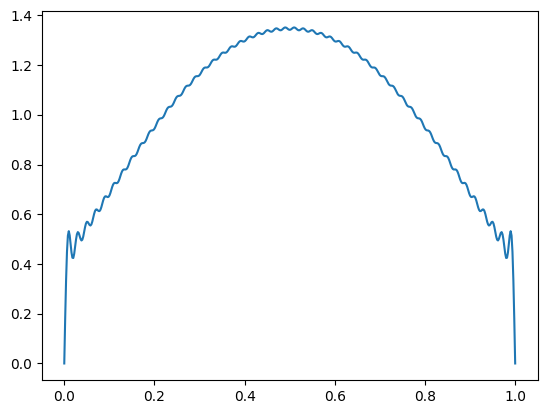

Entropy: -0.0482849294180255 3.801230163968938e-12
Integrate: 1.0
1 Order Moment: 0.5 0.0
2 Order Moment: 0.31145637567363654 0.5325952707886418
3 Order Moment: 0.2171845635104548 0.5937259509192562
4 Order Moment: 0.16257307697335469 0.598208796180043
5 Order Moment: 0.12779175324929548 0.5972217545315178
6 Order Moment: 0.10410268774341068 0.7626425482949855
 
beta = 0.01


KeyboardInterrupt: 

In [6]:
import csv
mu = [0.5, 0.292725, 0.188201, 0.134572, 0.100017, 0.0762008]
sigma = [1, 0.03517, 0.0488164, 0.0468082, 0.0465066, 0.0365858]
a_coefficient = [1.454172382534786,0.16604901289979257,0.10049858900197227,0.074001259918095,0.05832101368302116,0.04805286739705403,0.04084396491568953,0.03551677914258147,0.03142465003934288,0.028185115270084132,0.02555817867648074,0.02338587937101745,0.021560105956859754,0.02000441940325069,0.018663271230162953,0.017495337379468668,0.016469247270919033,0.015560762639660641,0.014750863262644725,0.014024417276494859,0.01336923819279532,0.012775403406295663,0.01223475387595126,0.011740521304605088,0.011287051548807086,0.010869557959633123,0.010483982063479952,0.010126906990523883,0.009795369195897031,0.009486820915764355,0.00919906138135131,0.008930184421451428,0.008678536801839025,0.00844268597869152,0.00822139511711914,0.008013605278979367,0.007818424769057069,0.007635126449903326,0.007463155405731864,0.00730215146886962,0.007151995390158373,0.007012896281948342,0.006885557084982947,0.00677149958197198,0.006673752145546859,0.006598468363145044,0.006559404740913983,0.0065940362253091205,0.006857163957472711,0.008620865065592669]

with open("Result2.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(1, 50):
        beta = 0.005 * i
        print("beta =", beta)
        s, a_coefficient, moment, freq = SCF(a_coefficient)
        writer.writerow([beta, s, moment, a_coefficient])
    csvfile.close()